<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="height:80px; display: inline"  alt="INSA"/></a> 

# Tutoriel: Détecter, la Discrimination Indirecte des Algorithmes d'Apprentissage Statistique de l'IA

# En chantier en python

**Résumé**
L'objectif de ce calepin est proposer les codes en python permettant de reproduire une petite partie des résultats obtenus avec le [tutoriel en R](https://github.com/wikistat/Fair-ML-4-Ethical-AI/blob/master/AdultCensus/AdultCensus-R-biasDetection.ipynb) de détection et correction élémentaire des biais et discriminations. Il est  indispensable d'avoir exécuté et étudié le tutoriel en R avant d'aborder celui en python qui est très restreint et encore en chantier.

Tout le début: préparation des données et apprentissage des algorithmes reprend (copier coller)les codes du [tutoriel](https://github.com/wikistat/Apprentissage/blob/master/Adult-Census/Apprent-Python-AdultCensus.ipynb) du dépôt sur l'[apprentissage](https://github.com/wikistat/Apprentissage).

## 1 Introduction
### 1.1 Les données
Des données publiques disponibles sur le site [UCI repository](http://archive.ics.uci.edu/ml/) sont extraites de la base de données issue du recensement réalisé aux Etats Unis en 1994. Les deux fichiers *train* et *test* on été réunis en un seul. Ces données son largement utilisées et font référence comme outil de *benchmark* pour comparer les performances de méthodes d’apprentissage. L’objectif est de prévoir, avec plus ou moins de biais, la variable binaire "revenu annuel" supérieur ou inférieur à 50k$. Cette prévision n'impacte pas la personne mais comme la démarche et le contexte sont tout à fait similaires à ce que pourrait faire une banque pour évaluer un risque de crédit, c'est exemple est très illustratif. Ce jeu de données est systématiquement utilisé (bac à sable) pour évaluer les propriétés des algorithmes d'apprentissage équitable ou loyal (*fair learning*) car, contrairement à beaucoup d'autres jeux de données utilisés pour cette fin (*e.g. german credit bank*), la vraie valeur de la variable cible est connue ainsi que l'origine ethnique des personnes concernées.

Dans les données initiales, 48.842 individus sont décrits par les 14 variables du tableau ci-dessous:


|Num|Libellé|Ensemble de valeurs|
|-|---------:|-------------------:|
|1|`Age`|real|
|2|`workClass`|Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked|
|3|`fnlwgt`|real|
|4|`education`|Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool|
|5|`educNum`|integer|
|6|`mariStat`|Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse|
|7|`occup`|Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces|
|8|`relationship`|Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried
|9|`origEthn`|White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black|
|10|`sex`|Female, Male|
|11|`capitalGain`|real| 
|12|`capitalLoss`|real|
|13|`hoursWeek`|real|
|14|`nativCountry`|United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands|
|15|`income`|>50K, <=50K|


### 1.2 Préparation des données

Le traitement commence par une préparation détaillée des données:
- lecture et prise en charge des données en remarquant que la variable `fnlwgt` (Final sampling weight) a un [statut particulier](http://web.cs.wpi.edu/~cs4341/C00/Projects/fnlwgt) pas très clair; elle est éliminée;
- suppression des observations présentant des données manquantes, erreurs ou incohérences,
- regroupement des modalités très dispersées, 
- suppression des variables redondantes. 

Cette phase est notoirement différente de la stratégie de Friedler et al. (2019) qui, par principe, analysent toutes les données brute sans le préalable d'une analyse statistique descriptive élémentaire.

### 1.3 Estimation des biais

Parmi tous les critères de biais existant susceptibles de mettre en évidence une discrimination indirecte (Zliobaitė, 2015)), trois ont été privilégiés (cf. Vermat et Rubin, 2018) dans le [tutoriel en R](https://github.com/wikistat/Fair-ML-4-Ethical-AI/blob/master/AdultCensus/AdultCensus-R-biasDetection.ipynb). 
1. discrimination indirecte par l'effet disproportionné: *disparate impact* ou *demographic equality*
2. comparaison des taux d'erreur conditionnels: *overall error equality*
3. comparaison des rapports de cote: *Conditional procedure accuracy equality* ou *disparate mistreatment* ou *equalized odds*.

Seul l'effet disproportionné est considéré ici.

## 2 Pris en charge et exploration des données
### 2.1 Lecture 
La lecture et la transformation des données brutes du dépôt de l'UCI sont obtenues directement en exécutant les codes ci-dessous. Analyser le code afin de comprendre les choix de transformations qui ont été réalisées sur les données brutes. 

Charger les données et le programme dans le répertoire courant en même temps que ce tutoriel ou changer de chemin pour y accéder directement. 

In [1]:
%matplotlib inline
# Importations 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
adult=pd.read_csv('adultTrainTest.csv')
adult.head()

,age,workClass,fnlwgt,education,educNum,mariStat,occup,relationship,origEthn,sex,capitalGain,capitalLoss,hoursWeek,nativCountry,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### 2.2 Regroupement des modalités trop peu fréquentes

In [2]:
def create_categorical_data(df, column_name):
    cat_columns = pd.Categorical(df[column_name], ordered=False)
    return cat_columns

In [3]:
print(np.sort(adult["mariStat"].unique()))

[' Divorced' ' Married-AF-spouse' ' Married-civ-spouse'
 ' Married-spouse-absent' ' Never-married' ' Separated' ' Widowed']


In [4]:
# mariStat
cat_name_dic = {" Never-married": "Never-Married", " Married-AF-spouse": "Married",
                " Married-civ-spouse": "Married", " Married-spouse-absent": "Not-Married",
                " Separated": "Not-Married", " Divorced": "Not-Married", " Widowed": "Widowed"}
adult['mariStat'] = adult.mariStat.map(cat_name_dic)

In [5]:
print(np.sort(adult["nativCountry"].unique()))

[' ?' ' Cambodia' ' Canada' ' China' ' Columbia' ' Cuba'
 ' Dominican-Republic' ' Ecuador' ' El-Salvador' ' England' ' France'
 ' Germany' ' Greece' ' Guatemala' ' Haiti' ' Holand-Netherlands'
 ' Honduras' ' Hong' ' Hungary' ' India' ' Iran' ' Ireland' ' Italy'
 ' Jamaica' ' Japan' ' Laos' ' Mexico' ' Nicaragua'
 ' Outlying-US(Guam-USVI-etc)' ' Peru' ' Philippines' ' Poland'
 ' Portugal' ' Puerto-Rico' ' Scotland' ' South' ' Taiwan' ' Thailand'
 ' Trinadad&Tobago' ' United-States' ' Vietnam' ' Yugoslavia']


In [6]:
# nativCountry
cat_country = {" Cambodia": "SE-Asia", " Canada": "British-Commonwealth", " China": "China", " Columbia": "South-America",
               " Cuba": "Other", " Dominican-Republic": "Latin-America", " Ecuador": "South-America",
               " El-Salvador": "South-America", " England": "British-Commonwealth", " France": "Euro_1",
               " Germany": "Euro_1", " Greece": "Euro_2", " Guatemala": "Latin-America", " Haiti": "Latin-America",
               " Holand-Netherlands": "Euro_1", " Honduras": "Latin-America", " Hong": "China", " Hungary": "Euro_2",
               " India": "British-Commonwealth", " Iran": "Other", " Ireland": "British-Commonwealth", " Italy": "Euro_1",
               " Jamaica": "Latin-America", " Japan": "Other", " Laos": "SE-Asia", " Mexico": "Latin-America",
               " Nicaragua": "Latin-America", " Outlying-US(Guam-USVI-etc)": "Latin-America", " Peru": "South-America",
               " Philippines": "SE-Asia", " Poland": "Euro_2", " Portugal": "Euro_2", " Puerto-Rico": "Latin-America",
               " Scotland": "British-Commonwealth", " South": "Euro_2", " Taiwan": "China", " Thailand": "SE-Asia",
               " Trinadad&Tobago": "Latin-America", " Vietnam": "SE-Asia", " United-States": "United-States",
               " Yugoslavia": "Euro_2"}
adult["nativCountry"] = adult.nativCountry.map(cat_country)

In [7]:
print(np.sort(adult["education"].unique()))

[' 10th' ' 11th' ' 12th' ' 1st-4th' ' 5th-6th' ' 7th-8th' ' 9th'
 ' Assoc-acdm' ' Assoc-voc' ' Bachelors' ' Doctorate' ' HS-grad'
 ' Masters' ' Preschool' ' Prof-school' ' Some-college']


In [8]:
# education
cat_educ = {" 10th": "Dropout", " 11th": "Dropout", " 12th": "Dropout", " 1st-4th": "Dropout", " 5th-6th": "Dropout",
            " 7th-8th": "Dropout", " 9th": "Dropout", " Assoc-acdm": "Associates", " Assoc-voc": "Associates",
            " Bachelors": "Bachelors", " Doctorate": "Doctorate", " HS-grad": "HS-grad", " Masters": "Masters",
            " Preschool": "Dropout", " Prof-school": "Prof-School", " Some-college": "HS-Graduate"}
adult["education"] = adult.education.map(cat_educ)

In [9]:
print(np.sort(adult["workClass"].unique()))

[' ?' ' Federal-gov' ' Local-gov' ' Never-worked' ' Private'
 ' Self-emp-inc' ' Self-emp-not-inc' ' State-gov' ' Without-pay']


In [10]:
# workClass
cat_work = {" Federal-gov": "Federal-Govt", " Local-gov": "Other-Govt", " State-gov": "Other-Govt", " Private": "Private",
            " Self-emp-inc": "Self-Employed", " Self-emp-not-inc": "Self-Employed", " Without-pay": "Not-Working",
            " Never-worked": "Not-Working"}
adult["workClass"] = adult.workClass.map(cat_work)

In [11]:
print(np.sort(adult["occup"].unique()))

[' ?' ' Adm-clerical' ' Armed-Forces' ' Craft-repair' ' Exec-managerial'
 ' Farming-fishing' ' Handlers-cleaners' ' Machine-op-inspct'
 ' Other-service' ' Priv-house-serv' ' Prof-specialty' ' Protective-serv'
 ' Sales' ' Tech-support' ' Transport-moving']


In [12]:
# occup
cat_occup = {" Adm-clerical": "Admin", " Craft-repair": "Blue-Collar", " Exec-managerial": "White-Collar",
             " Farming-fishing": "Blue-Collar", " Handlers-cleaners": "Blue-Collar", " Machine-op-inspct": "Blue-Collar",
             " Other-service": "Service", " Priv-house-serv": "Service", " Prof-specialty": "Professional",
             " Protective-serv": "Other-occups", " Sales": "Sales", " Tech-support": "Other-occups",
             " Transport-moving": "Blue-Collar"}
adult["occup"] = adult.occup.map(cat_occup)

In [13]:
print(np.sort(adult["origEthn"].unique()))

[' Amer-Indian-Eskimo' ' Asian-Pac-Islander' ' Black' ' Other' ' White']


In [14]:
# origEthn
cat_orig = {" White": "CaucYes", " Black": "CaucNo", " Amer-Indian-Eskimo": "CaucNo", " Asian-Pac-Islander": "CaucNo",
            " Other": "CaucNo"}
adult["origEthn"] = adult.origEthn.map(cat_orig)

In [15]:
print(np.sort(adult["income"].unique()))

[' <=50K' ' >50K']


In [16]:
def create_categorical_data_rename(df, column_name, cat_name_dic):
    cat_columns = pd.Categorical(df[column_name], ordered=False)
    new_categorie = [cat_name_dic[old_name] for old_name in cat_columns.categories]
    return cat_columns.rename_categories(new_categorie)

In [17]:
adult["income"] = create_categorical_data_rename(adult, "income", {" <=50K": "incLow", " >50K": "incHigh"})

In [18]:
for name in ["workClass", "education", "mariStat", "occup", "relationship", "origEthn", "sex", "nativCountry"]:
    adult[name] = create_categorical_data(adult, name)

### 2.3 Transformations de variables quantitatives
Les distributions sont trop disymétriques pour intégrer un modèle linéaire sensible à des valeurs extrêmes.

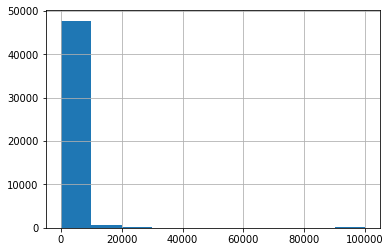

In [19]:
adult["capitalGain"].hist()
plt.show()

In [20]:
adult["LcapitalGain"] = np.log(1 + adult["capitalGain"])
adult["LcapitalLoss"] = np.log(1 + adult["capitalLoss"])

### 2.4 Suppressions de données manquantes ou incohérentes

In [21]:
adult = adult[np.logical_not(adult.isnull().any(axis=1))]
adult.head()

,age,workClass,fnlwgt,education,educNum,mariStat,occup,relationship,origEthn,sex,capitalGain,capitalLoss,hoursWeek,nativCountry,income,LcapitalGain,LcapitalLoss
0,39,Other-Govt,77516,Bachelors,13,Never-Married,Admin,Not-in-family,CaucYes,Male,2174,0,40,United-States,incLow,7.684784,0.0
1,50,Self-Employed,83311,Bachelors,13,Married,White-Collar,Husband,CaucYes,Male,0,0,13,United-States,incLow,0.000000,0.0
2,38,Private,215646,HS-grad,9,Not-Married,Blue-Collar,Not-in-family,CaucYes,Male,0,0,40,United-States,incLow,0.000000,0.0
3,53,Private,234721,Dropout,7,Married,Blue-Collar,Husband,CaucNo,Male,0,0,40,United-States,incLow,0.000000,0.0
4,28,Private,338409,Bachelors,13,Married,Professional,Wife,CaucNo,Female,0,0,40,Other,incLow,0.000000,0.0


In [22]:
adult = adult[(adult["sex"] != "Female") | (adult["relationship"] != "Husband")]
adult = adult[(adult["sex"] != "Male") | (adult["relationship"] != "Wife")]

### 2.5 Description statistique élémentaire
Mettre en évidence des difficultés présentes sur certaines variables ou couples de variables.

In [23]:
adult.describe()

,age,fnlwgt,educNum,capitalGain,capitalLoss,hoursWeek,LcapitalGain,LcapitalLoss
count,45208.000000,4.520800e+04,45208.000000,45208.000000,45208.000000,45208.000000,45208.000000,45208.000000
mean,38.550035,1.897257e+05,10.118298,1101.610003,88.581114,40.937776,0.740792,0.355432
std,13.218340,1.056474e+05,2.552960,7507.512510,404.927674,12.007784,2.466579,1.595791
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,28.000000,1.173810e+05,9.000000,0.000000,0.000000,40.000000,0.000000,0.000000
50%,37.000000,1.783120e+05,10.000000,0.000000,0.000000,40.000000,0.000000,0.000000
75%,47.000000,2.379155e+05,13.000000,0.000000,0.000000,45.000000,0.000000,0.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,11.512925,8.379539


**Q** Que dire de la distribution de la variable `age`, de celle `income` ?

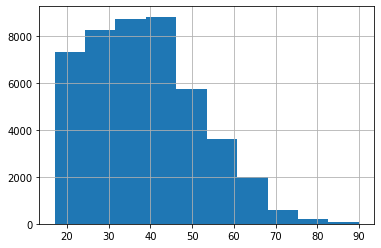

In [24]:
adult["age"].hist()
plt.show()

In [25]:
adult["income"].value_counts()

incLow     34004
incHigh    11204
Name: income, dtype: int64

In [26]:
adult["relationship"].value_counts()

 Husband           18661
 Not-in-family     11697
 Own-child          6624
 Unmarried          4788
 Wife               2091
 Other-relative     1347
Name: relationship, dtype: int64

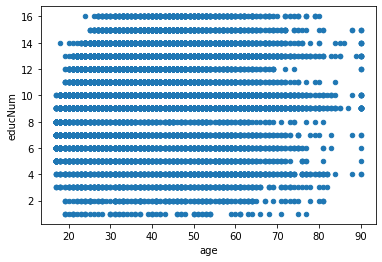

In [27]:
adult.plot(kind="scatter",x="age",y="educNum")
plt.show()

**Q** Que dire des liaisons : `age x hoursWeek`, `age x income`, `sex x income` ?

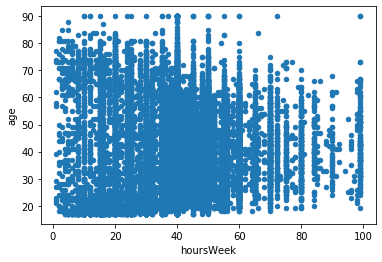

In [28]:
adult.plot(kind="scatter",x="hoursWeek",y="age")
plt.show()

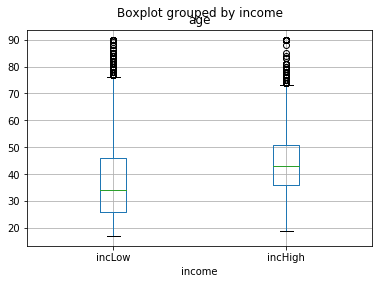

In [29]:
adult.boxplot(column="age",by="income")
plt.show()

**Q** Que dire des redondances ci-dessous?

In [30]:
table=pd.crosstab(adult["education"],adult["educNum"])
print(table) 

educNum      1    2    3    4    5     6     7    8      9     10    11    12  \
education                                                                       
Associates    0    0    0    0    0     0     0    0      0     0  1959  1507   
Bachelors     0    0    0    0    0     0     0    0      0     0     0     0   
Doctorate     0    0    0    0    0     0     0    0      0     0     0     0   
Dropout      72  222  449  823  676  1223  1619  576      0     0     0     0   
HS-Graduate   0    0    0    0    0     0     0    0      0  9895     0     0   
HS-grad       0    0    0    0    0     0     0    0  14778     0     0     0   
Masters       0    0    0    0    0     0     0    0      0     0     0     0   
Prof-School   0    0    0    0    0     0     0    0      0     0     0     0   

educNum        13    14   15   16  
education                          
Associates      0     0    0    0  
Bachelors    7569     0    0    0  
Doctorate       0     0    0  544  
Dropout  

In [31]:
table=pd.crosstab(adult["mariStat"],adult["relationship"])
print(table)

relationship    Husband   Not-in-family   Other-relative   Own-child  \
mariStat                                                               
Married           18661              19              184         126   
Never-Married         0            6686              819        5862   
Not-Married           0            4305              285         616   
Widowed               0             687               59          20   

relationship    Unmarried   Wife  
mariStat                          
Married                 0   2091  
Never-Married        1223      0  
Not-Married          3054      0  
Widowed               511      0  


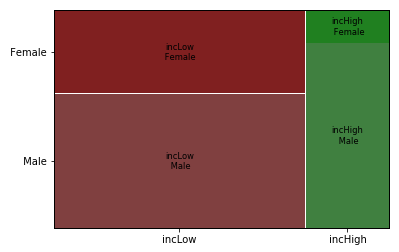

In [32]:
# Mosaic plots
from statsmodels.graphics.mosaicplot import mosaic
mosaic(adult,["income","sex"])
plt.show()

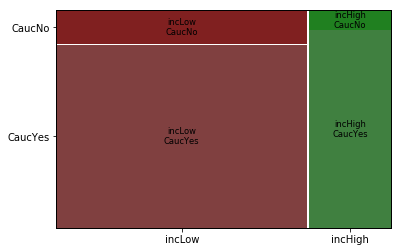

In [33]:
from statsmodels.graphics.mosaicplot import mosaic
mosaic(adult,["income","origEthn"])
plt.show()

Quelques modifications comlémentaires sont apportées de la base. Des variables sont supprimées afin de ne garder qu'une seule présence d'une information sensible: genre et origine ethnique.
- Suppression de la variable `fnlwgt` qui n'a guère de signification pour cette analyse.
- Suppression de la variable `workClass` redondante acvec l'occupation.
- Suppression de la variable `education` redondante avec le niveau de diplôme.
- Suppression de la variable `capitalGain` et `capitalLoss` remplacée par leur transformations log.
- Création d'une variable binaire `Child`: présence ou non d'enfants.
- Suppression de la variable `relationship` redondante avec le genre et le statut marital.
- Suppression de la variable `nativCountry` redondante avec l'origine ethnique.

In [34]:
print(np.sort(adult["relationship"].unique()))

[' Husband' ' Not-in-family' ' Other-relative' ' Own-child' ' Unmarried'
 ' Wife']


In [35]:
cat_orig = {' Husband':"ChildNo",' Not-in-family':"ChildNo",' Other-relative':"ChildNo",' Own-child':"ChildYes",' Unmarried':"ChildNo",' Wife':"ChildNo"}
adult["child"] = adult.relationship.map(cat_orig)

In [36]:
adult=adult.drop(["workClass","education","fnlwgt","nativCountry","relationship", 
                  "capitalGain", "capitalLoss"],axis=1)

In [37]:
adult.head()

,age,educNum,mariStat,occup,origEthn,sex,hoursWeek,income,LcapitalGain,LcapitalLoss,child
0,39,13,Never-Married,Admin,CaucYes,Male,40,incLow,7.684784,0.0,ChildNo
1,50,13,Married,White-Collar,CaucYes,Male,13,incLow,0.000000,0.0,ChildNo
2,38,9,Not-Married,Blue-Collar,CaucYes,Male,40,incLow,0.000000,0.0,ChildNo
3,53,7,Married,Blue-Collar,CaucNo,Male,40,incLow,0.000000,0.0,ChildNo
4,28,13,Married,Professional,CaucNo,Female,40,incLow,0.000000,0.0,ChildNo


### 2.6 Variables indicatrices

**Q** Pourquoi l’introduction de *dummy variables*? 

In [38]:
adultDum=pd.get_dummies(adult[["mariStat","occup","origEthn","sex","child"]])
adultDum.head()

,mariStat_Married,mariStat_Never-Married,mariStat_Not-Married,mariStat_Widowed,occup_Admin,occup_Blue-Collar,occup_Other-occups,occup_Professional,occup_Sales,occup_Service,occup_White-Collar,origEthn_CaucNo,origEthn_CaucYes,sex_ Female,sex_ Male,child_ChildNo,child_ChildYes
0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0
1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0
2,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0
3,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0
4,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0


In [39]:
adultJoin = adult[["age","educNum","hoursWeek","LcapitalGain","LcapitalLoss","income"]].join(adultDum)

In [40]:
adultJoin.head()

,age,educNum,hoursWeek,LcapitalGain,LcapitalLoss,income,mariStat_Married,mariStat_Never-Married,mariStat_Not-Married,mariStat_Widowed,...,occup_Professional,occup_Sales,occup_Service,occup_White-Collar,origEthn_CaucNo,origEthn_CaucYes,sex_ Female,sex_ Male,child_ChildNo,child_ChildYes
0,39,13,40,7.684784,0.0,incLow,0,1,0,0,...,0,0,0,0,0,1,0,1,1,0
1,50,13,13,0.000000,0.0,incLow,1,0,0,0,...,0,0,0,1,0,1,0,1,1,0
2,38,9,40,0.000000,0.0,incLow,0,0,1,0,...,0,0,0,0,0,1,0,1,1,0
3,53,7,40,0.000000,0.0,incLow,1,0,0,0,...,0,0,0,0,1,0,0,1,1,0
4,28,13,40,0.000000,0.0,incLow,1,0,0,0,...,1,0,0,0,1,0,1,0,1,0


In [41]:
adult.shape

(45208, 11)

### 2.7 Préparation des échantillons
La base de données est réduite par tirage aléatoire puis divisée en deux échantillons d'apprentissage et de test.

In [42]:
# possibilité de réduire la taille de l'apprentissage par échantillonnage aléatoire ou pas
ind_ech = np.random.choice(adultJoin.index.values, 20000, replace=False)
#adultEch=adultJoin.loc[ind_ech]
adultEch=adultJoin
# Variable cible
Y=adultEch["income"]
# Variables prédictives
X=adultEch.drop(["income"],axis=1)

In [43]:
from sklearn.model_selection import train_test_split  
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=11)

In [44]:
sorted(X_train)

['LcapitalGain',
 'LcapitalLoss',
 'age',
 'child_ChildNo',
 'child_ChildYes',
 'educNum',
 'hoursWeek',
 'mariStat_Married',
 'mariStat_Never-Married',
 'mariStat_Not-Married',
 'mariStat_Widowed',
 'occup_Admin',
 'occup_Blue-Collar',
 'occup_Other-occups',
 'occup_Professional',
 'occup_Sales',
 'occup_Service',
 'occup_White-Collar',
 'origEthn_CaucNo',
 'origEthn_CaucYes',
 'sex_ Female',
 'sex_ Male']

## 3 Prévision du seuil de revenu 
Une comparaison détaillée (cf. le [tutoriel](https://github.com/wikistat/Apprentissage/blob/master/Adult-Census/Apprent-Python-AdultCensus.ipynb)) de la plupart des modèles et algorithmes de prévision du seuil de revenu en fonction des différentes variables met en évidence des résultats de prévision un peu meilleurs obtenus par l'algorithme de *gradient boosting* (version xtrem). Néanmoins, on peut se limiter ici à un choix plus restreint de modèles et algorithmes pour comprendre l'impact sur la discrimination.
- la régression logistique (linéaire) interprétable; 
- les forêts aléatoires (non linéaire) conduisent à une meilleure précision mais sans capacité d'interprétation,
- *gradient boosting* (idem).

### 3.1 Prévision par [régression logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf)
**Q** Comment est opérée la sélection de variables? 

**Q** Commenter  les options de la commande  `GridSearchCV`. A quoi sert `param` ?

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import time
tps0=time.perf_counter()
# Optimisation du paramètre de pénalisation
# grille de valeurs
param=[{"C":[0.9,1,1.1,1.2,1.3,1.4]}]
logit = GridSearchCV(LogisticRegression(penalty="l1",solver="liblinear"), param,cv=10,n_jobs=-1)
logitOpt=logit.fit(X_train, Y_train)  # GridSearchCV est lui même un estimateur
# paramètre optimal
logitOpt.best_params_["C"]
tps1=(time.perf_counter()-tps0)
print("Temps logit = %f, Meilleur taux = %f, Meilleur paramètre = %s" % (tps1,
                              1.-logitOpt.best_score_,logitOpt.best_params_))

Temps logit = 34.500329, Meilleur taux = 0.162224, Meilleur paramètre = {'C': 0.9}


In [46]:
ClogOpt=logitOpt.best_params_['C'] # pour des étapes ultérieures

In [47]:
# erreur sur l'échantillon test
1-logitOpt.score(X_test, Y_test)

0.16168989161689895

In [48]:
# Prévision
y_chap = logitOpt.predict(X_test)
# matrice de confusion
table=pd.crosstab(y_chap,Y_test)
print(table)

income   incLow  incHigh
row_0                   
incHigh     552     1308
incLow     6272      910


**Q** Quels algorithmes pourraient être exécutés en R pour la régression logistique? 

**Q** Que dire de l'interprétabilité des résultats par rapport à ceux de R?

In [49]:
# Coefficients
LogisticRegression(penalty="l1",C=logitOpt.best_params_['C'],
                   solver='liblinear').fit(X_train, Y_train).coef_

array([[-0.02267308, -0.2855071 , -0.02649611, -0.2053974 , -0.14904139,
        -0.23787639,  2.1346844 ,  1.8665767 ,  1.89294972,  1.19339137,
         1.52340342,  0.87779431,  0.75066762,  1.04773102,  2.18142349,
         0.50819658,  1.23348408,  1.10804293,  1.23411548,  1.03835993,
         1.844434  ,  2.78551986]])

### 3.2 [Forêts aléatoires](http://wikistat.fr/pdf/st-m-app-agreg.pdf)
En R, il peut être intéressant de construire un arbre binaire de classification. 

**Q** Pourquoi un arbre fourni par `scikit-learn` présente beaucoup moins d'intérêt?

**Q** Commenter les choix de tous les paramètres ci-dessous.

In [50]:
from sklearn.ensemble import RandomForestClassifier 
# définition des paramètres
forest = RandomForestClassifier(n_estimators=500, 
   criterion='gini', max_depth=None,
   min_samples_split=6, min_samples_leaf=5, 
   max_features='auto', max_leaf_nodes=None,
   bootstrap=True, oob_score=True,n_jobs=-1)
# apprentissage
rfFit = forest.fit(X_train,Y_train)
print(1-rfFit.oob_score_)

0.13952330918542277


In [51]:
# erreur de prévision sur le test
1-rfFit.score(X_test,Y_test)

0.13802256138022562

In [52]:
# optimisation du paramètre
import time
from sklearn.model_selection import GridSearchCV
tps0=time.perf_counter()
param=[{"max_features":list(range(2,10,1))}]
rf= GridSearchCV(RandomForestClassifier(n_estimators=500,min_samples_split=6, min_samples_leaf=5,n_jobs=-1),param,cv=10,n_jobs=-1)
rfOpt=rf.fit(X_train, Y_train)
# paramètre optimal
tps1=(time.perf_counter()-tps0)
print("Temps r forest = %f, Meilleur taux = %f, Meilleur paramètre = %s" % (tps1,
                                    1. - rfOpt.best_score_,rfOpt.best_params_))

/home-local/pbesse/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Temps r forest = 430.715286, Meilleur taux = 0.139385, Meilleur paramètre = {'max_features': 6}


In [53]:
CrfOpt=rfOpt.best_params_["max_features"]

In [54]:
# erreur de prévision sur le test
1-rfOpt.score(X_test,Y_test)

0.13746958637469586

In [55]:
# prévision
y_chap = rfFit.predict(X_test)
# matrice de confusion
table=pd.crosstab(y_chap,Y_test)
print(table)

income   incLow  incHigh
row_0                   
incHigh     396     1366
incLow     6428      852


In [56]:
rf= RandomForestClassifier(n_estimators=100,max_features=6, min_samples_leaf=5)
rfFit=rf.fit(X_train, Y_train)
# Importance décroissante des variables
importances = rfFit.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(20):
    print(X_train.columns[indices[f]], importances[indices[f]])

mariStat_Married 0.1905870284213846
LcapitalGain 0.18560852944511605
educNum 0.17593880376839263
age 0.115053580536087
mariStat_Never-Married 0.07320861988048329
hoursWeek 0.06481437048596819
LcapitalLoss 0.050166906346060476
occup_Blue-Collar 0.028259067988264025
mariStat_Not-Married 0.021556610732085247
occup_White-Collar 0.01777584671588094
sex_ Female 0.013611664630768374
occup_Professional 0.012092597282095031
occup_Service 0.011801311482990316
sex_ Male 0.0110114796965793
child_ChildNo 0.00472872087521124
occup_Sales 0.004397059365435663
child_ChildYes 0.0040502941391956405
occup_Admin 0.0034247582355285563
mariStat_Widowed 0.0033161806125946054
occup_Other-occups 0.0031841105678186974


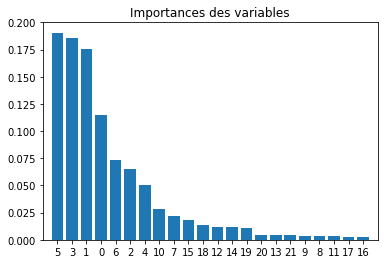

In [57]:
# Graphe des importances
plt.figure()
plt.title("Importances des variables")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

**Q** Comment est obtenu le graphique ? Quelle importance ? Comment interpréter ces résultats ?

### 3.3 [Gradient boosting](http://wikistat.fr/pdf/st-m-app-agreg.pdf)
Pour une raison non identifiée, l'implémentation de l'algorithme des forêts aléatoires dans `scikit-learn`est moins performante: erreur de prévision plus importante, sur ces données que l'implémentation en R de la librairie historique `randomForest`. L'algorithme *machine gradient boosting* est exécuté pour retrouver des performances similaires.

**Q** Pourquoi pas de paramètre `njobs=-1`? 

**Q** En plus de celui optimisé, quels sont les 2 principaux paramètres de cet algorithme laissés par défaut ?

In [58]:
from sklearn.ensemble import GradientBoostingClassifier
tps0=time.perf_counter()
param=[{"n_estimators":[300, 350, 400]}]
gbm= GridSearchCV(GradientBoostingClassifier(),param,cv=10)
gbmOpt=gbm.fit(X_train, Y_train)
# paramètre optimal
tps1=(time.perf_counter()-tps0)
print("Temps boosting = %f, Meilleur taux = %f, Meilleur paramètre = %s" % (tps1,
                        1. - gbmOpt.best_score_,gbmOpt.best_params_))

Temps boosting = 215.557376, Meilleur taux = 0.133191, Meilleur paramètre = {'n_estimators': 400}


In [59]:
CgbmOpt=gbmOpt.best_params_["n_estimators"]

In [60]:
# erreur de prévision sur le test
1-gbmOpt.score(X_test,Y_test)

0.1333775713337757

In [61]:
# prévision de l'échantillon test
y_chap = gbmOpt.predict(X_test)
# matrice de confusion
table=pd.crosstab(y_chap,Y_test)
print(table)

income   incLow  incHigh
row_0                   
incHigh     427     1439
incLow     6397      779


### 3.4 Comparaison des méthodes
#### Tracé des [Courbes ROC](http://wikistat.fr/pdf/st-m-app-risque.pdf)

**Q** En cohérence avec les résultats précédents, quelle est la courbe la plus au dessus des autres? Commenter ce graphique, que signifie AUC ?

In [62]:
from sklearn.metrics import roc_curve
listMethod=[["GBM",gbmOpt],["RF",rfOpt],["Logit",logitOpt]]

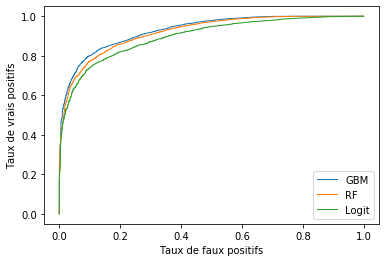

In [63]:
# Courbes ROC des précédents modèles optimaux
for method in enumerate(listMethod):
    probas_ = method[1][1].fit(X_train, Y_train).predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(Y_test,probas_[:,1], pos_label="incLow")
    plt.plot(fpr, tpr, lw=1,label="%s"%method[1][0]),
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.legend(loc="best")
plt.show()

#### [Validation croisée](http://wikistat.fr/pdf/st-m-app-risque.pdf) *Monte Carlo*

Le tutoriel du dépôt d'apprentissage compare finement les performances des algoritmes. Ce n'est l'objectif ici.

## 4 Détection des discriminations
### 4.1 Estimation de l'effet disproportionné
Fontions d'estimation pontuelle et par intervalle de confiance de l'effet disproportionné.

In [84]:
def DI(tab):
    """
    Calcule le disparate impact ponctuel d'une table de contingence 
    Colonnes = Variable sensible
    Lignes = variable cible
    """
    tab_np = tab.to_numpy()
    DI = (tab_np[0,0] / (tab_np[1,0] + tab_np[0,0])) / (tab_np[0,1] / (tab_np[1,1] + tab_np[0,1]))
    return DI

In [83]:
def dispImp(var_sens, var_cible, alpha=0.05):
    """
    Estimation du disparate impact par intervalle de confiance  
                                                             
  Cette fonction prend trois arguments en entrée :           
    - La variable binaire considérée comme sensible          
    - La variable cible Y ou sa prévision                    
    - alpha par défaut 0.05                                  
  Elle renvoie la valeur Tn du disparate impact et des bornes de l'intervalle de confiance                
  Attention à l'ordre lexicographique des niveaux des facteurs, le premier est par convention celui jugé défavorable  
    """

    S = var_sens.astype('int')
    Y = var_cible.astype('int')
    n = len(S)
    
    pi_1 = np.sum(S)/n #estimated P(S=1)
    pi_0 = 1 - pi_1 #estimated P(S=0)
    p_1 = np.sum(S * Y) / n #estimated P(g(X)=1, S=1)
    p_0 = np.sum((1 - S) * Y) / n #estimated P(g(X)=1, S=0)
    Tn = p_0 * pi_1 / (p_1 * pi_0) # disparate impact
    grad_h = lambda x: np.array((x[3]/(x[1]*x[2]), -x[0]*x[3]/(x[1]**2 * x[2]), -x[0]*x[3]/(x[2]**2 * x[1]), x[0]/(x[2]*x[1])))
    grad = grad_h([p_0, p_1, pi_0, pi_1])
    Cov_4 = np.array([(0, -p_0*p_1, pi_1*p_0, -pi_1*p_0), (0, 0, -pi_0*p_1, pi_0*p_1), (0,0,0,-pi_0*pi_1), (0,0,0,0)]).T
    Cov_4 = Cov_4 + Cov_4.T + np.diag((p_0*(1-p_0), p_1*(1-p_1),pi_0*pi_1,pi_0*pi_1))
    sigma = np.sqrt((grad.dot(Cov_4)).dot(grad))
    
    lower_lim = Tn - (sigma * scipy.stats.norm.ppf(1-alpha/2)) / np.sqrt(n)
    upper_lim = Tn + (sigma * scipy.stats.norm.ppf(1-alpha/2)) / np.sqrt(n)
    
    return np.array([lower_lim, Tn, upper_lim])

In [85]:
logitFixe = LogisticRegression(penalty="l1",solver="liblinear", C=ClogOpt)
logitFixe.fit(X_train, Y_train)
y_chap_logit = logitFixe.predict(X_test)

In [86]:
rfFixe = RandomForestClassifier(n_estimators=500, max_features=CrfOpt)
rfFixe.fit(X_train, Y_train)
y_chap_rf = rfFixe.predict(X_test)

In [72]:
gbmFixe = GradientBoostingClassifier(n_estimators=CgbmOpt)
gbmFixe.fit(X_train, Y_train)
y_chap_gbm = gbmFixe.predict(X_test)

In [73]:
# récupération des matrices de confusion
tableSex_logit = pd.crosstab(y_chap_logit, X_test['sex_ Male'].map({0: "Female", 1: "Male"}),
                          rownames=['Sex'], colnames=['Inc'])
tableSex_rf = pd.crosstab(y_chap_rf, X_test['sex_ Male'].map({0: "Female", 1: "Male"}), 
                          rownames=['Sex'], colnames=['Inc'])
tableSex_gbm = pd.crosstab(y_chap_gbm, X_test['sex_ Male'].map({0: "Female", 1: "Male"}), 
                          rownames=['Sex'], colnames=['Inc'])

In [74]:
#Calcul des DI ponctuels
diSex_logit = DI(tableSex_logit)
diSex_rf = DI(tableSex_rf)
diSex_gbm = DI(tableSex_gbm)

In [75]:
print(diSex_logit)
print(diSex_rf)
print(diSex_gbm)

0.2069863824748372
0.33678783191544215
0.30320683760683764


In [76]:
dispimpSex_theorique = dispImp(X_test["sex_ Male"].values, Y_test.map({"incLow": 0, "incHigh": 1}))

In [77]:
dispimpSex_logit = dispImp(X_test["sex_ Male"].values, 
                            pd.Series(y_chap_logit).map({"incLow": 0, "incHigh": 1}).values)
dispimpSex_rf = dispImp(X_test["sex_ Male"].values, 
                         pd.Series(y_chap_rf).map({"incLow": 0, "incHigh": 1}).values)
dispimpSex_gbm = dispImp(X_test["sex_ Male"].values, 
                          pd.Series(y_chap_gbm).map({"incLow": 0, "incHigh": 1}).values)

In [78]:
print(dispimpSex_theorique)
print(dispimpSex_logit)
print(dispimpSex_rf)
print(dispimpSex_gbm)

[0.3138586  0.35226685 0.39067511]
[0.17572322 0.20698638 0.23824955]
[0.29718351 0.33678783 0.37639216]
[0.26440398 0.30320684 0.34200969]


**Q** Comparer ces intervalles de confiance et avec ceux obtenus en R. Commenter.

### 4.2 Représentation graphique

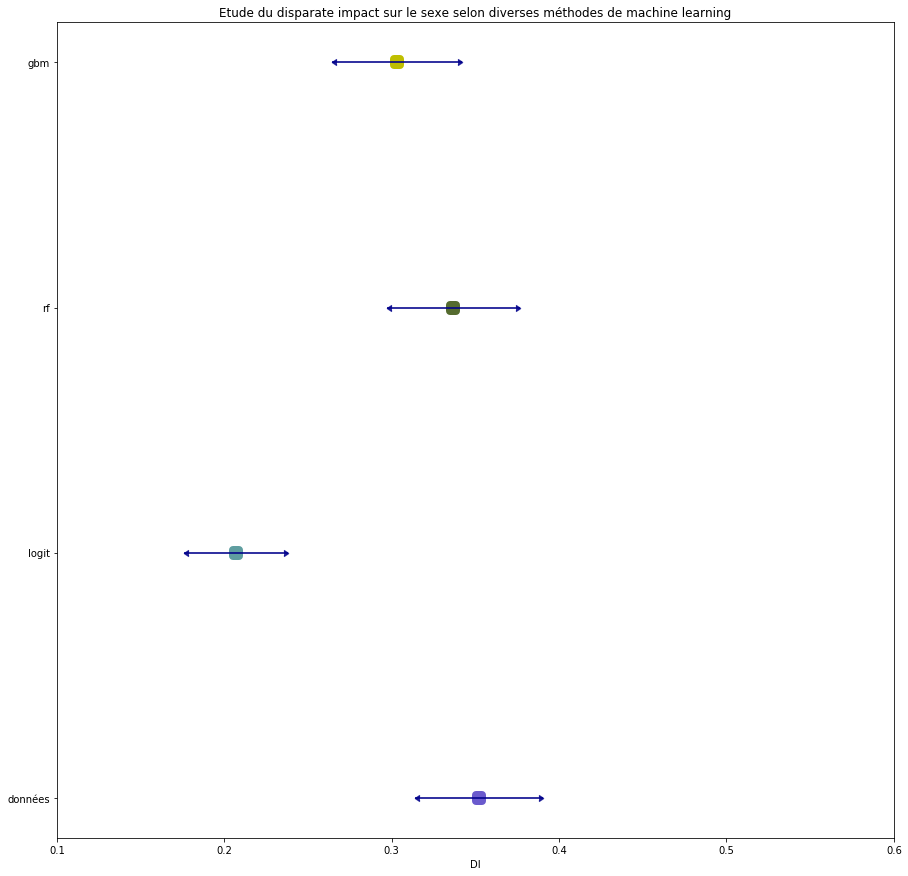

In [79]:
fig, ax = plt.subplots(figsize=(15, 15))
# Create a dataframe
IC_l = [x[0] for x in [dispimpSex_theorique, dispimpSex_logit, dispimpSex_rf, dispimpSex_gbm]]
mean = [x[1] for x in [dispimpSex_theorique, dispimpSex_logit, dispimpSex_rf, dispimpSex_gbm]]
IC_h = [x[2] for x in [dispimpSex_theorique, dispimpSex_logit, dispimpSex_rf, dispimpSex_gbm]]

df = pd.DataFrame({'method': list(map(str, ["données", "logit", "rf", "gbm"])), 
                   'IC_l' : IC_l , 'mean' : mean, 'IC_h' : IC_h })

# Reorder it following the values of the first value:

my_range=range(1,len(df.index)+1)

col = [ "slateblue",  "cadetblue", "darkolivegreen", "y"]



plt.hlines(y=my_range, xmin=df['IC_l'], xmax=df['IC_h'], color='darkblue', alpha=0.8, linewidth=2)
plt.scatter(df['IC_l'], my_range, color='darkblue', alpha=0.8, marker=4)
plt.scatter(df['mean'], my_range, color=col, alpha=1, marker="s", linewidths=8)
plt.scatter(df['IC_h'], my_range, color='darkblue', alpha=0.8, marker=5)
axes = plt.gca()
axes.set_xlim((0.1, 0.6))
# plt.xlim((0.1, 0.7))
# Add title and axis names
plt.yticks(my_range, df['method'])
plt.title("Etude du disparate impact sur le sexe selon diverses méthodes de machine learning", loc='center')
plt.xlabel('DI')

plt.show()

In [80]:
def graphesIC(x, confint, xmax=1):
    tab_colors=['turquoise', 'lightcoral', 'mediumspringgreen', 'violet']
    tab_labels=['Données', 'Régression logistique', 'Forêts aléatoires', 'Gradient Boosting Machine'] 
    plt.figure(figsize=(15,15))
    axes = plt.gca()
    axes.set_xlim([0,xmax])
    axes.set_yticklabels([])
    for i in range(np.shape(x)[0]):
        plt.errorbar(range(i,i+1), y[i], yerr=confint[i], fmt='o', color='white',
                         ecolor=tab_colors[i], elinewidth=6, capsize=10, capthick=5);
        if i==0 and donnees:
            plt.scatter(range(i,i+1), y[i], marker='o', s=400, color=tab_colors[i], label=tab_labels[i])
        if i>0 and (i+1)%3==0:
            plt.scatter(range(i,i+1), y[i], marker='o', s=400, color=tab_colors[i], label=tab_labels[i])
        else:
            plt.scatter(range(i,i+1), y[i], marker='o', s=400, color=tab_colors[i])
    plt.legend(labelspacing=1.5, fontsize=13)
    plt.title('Intervalles de confiance du '+title+ 'pourchaque modèle', fontsize=25)
    plt.show()

In [81]:
graphesIC(tab_intervalles[:,1], tab_intervalles[:,2]-tab_intervalles[:,1], 'DI')   

NameError: name 'tab_intervalles' is not defined